# Load Libraries

In [1]:
#https://machinelearningmastery.com/machine-learning-in-python-step-by-step/
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
#https://towardsdatascience.com/end-to-end-python-framework-for-predictive-modeling-b8052bb96a78
%matplotlib inline
import datetime as dt
import pyodbc 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# data colelctFion and preprocessing
#from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv
# for data visualisation and statistical analysis
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
Cnt2SQL = pyodbc.connect(
"Driver={SQL Server Native Client 11.0};"
    #REPLACE TCOKER with your own Server Name(you can find the server name on the connect window when you open sql mgt studio)
 "Server=DESKTOP-NEDV4G5;"
    # REPLACE AdventureWorksDW2012 with the database you want
"Database=AdventureWorksDW2012;"
"Trusted_Connection=yes;")

# Import Fact Internet Sales

In [3]:
fis = pd.read_sql("""SELECT 
[CustomerKey],
[SalesTerritoryKey],
[OrderQuantity],
[SalesOrderNumber],
[SalesAmount],
[OrderDate]
FROM [dbo].[FactInternetSales] 
""", Cnt2SQL)

In [5]:
fis.head()

,CustomerKey,SalesTerritoryKey,OrderQuantity,SalesOrderNumber,SalesAmount,OrderDate
0,21768,6,1,SO43697,3578.2700,2010-12-29
1,28389,7,1,SO43698,3399.9900,2010-12-29
2,25863,1,1,SO43699,3399.9900,2010-12-29
3,14501,4,1,SO43700,699.0982,2010-12-29
4,11003,9,1,SO43701,3399.9900,2010-12-29


In [6]:
fis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 6 columns):
CustomerKey          60398 non-null int64
SalesTerritoryKey    60398 non-null int64
OrderQuantity        60398 non-null int64
SalesOrderNumber     60398 non-null object
SalesAmount          60398 non-null float64
OrderDate            60398 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 2.8+ MB


In [7]:
max(fis.OrderDate)

Timestamp('2014-01-28 00:00:00')

- this date is important because it will be used to generate the CUTOFF DATE for our churn later on
- we will subtract 8 months from this date to create the cut off period

In [8]:
fis.count().head()

CustomerKey          60398
SalesTerritoryKey    60398
OrderQuantity        60398
SalesOrderNumber     60398
SalesAmount          60398
dtype: int64

In [9]:
fis.sort_values(['CustomerKey', 'SalesOrderNumber']).head()

,CustomerKey,SalesTerritoryKey,OrderQuantity,SalesOrderNumber,SalesAmount,OrderDate
96,11000,9,1,SO43793,3399.99,2011-01-19
6396,11000,9,1,SO51522,2319.99,2013-01-18
6397,11000,9,1,SO51522,21.98,2013-01-18
19223,11000,9,1,SO57418,2384.07,2013-05-03
19224,11000,9,1,SO57418,28.99,2013-05-03


In [10]:
# checking for duplicates
print(any(fis.duplicated()))

True


In [11]:
fis.isnull().sum()

CustomerKey          0
SalesTerritoryKey    0
OrderQuantity        0
SalesOrderNumber     0
SalesAmount          0
OrderDate            0
dtype: int64

# Summarize & aggregate the facts internet sales data

In [12]:
new_fis = fis.groupby(['CustomerKey','SalesOrderNumber','OrderDate','SalesTerritoryKey']).agg({'SalesAmount':'sum','OrderQuantity':'sum'})

In [13]:
new_fis.head()

SalesAmount  \
CustomerKey SalesOrderNumber OrderDate  SalesTerritoryKey                
11000       SO43793          2011-01-19 9                      3399.99   
            SO51522          2013-01-18 9                      2341.97   
            SO57418          2013-05-03 9                      2507.03   
11001       SO43767          2011-01-15 9                      3374.99   
            SO51493          2013-01-16 9                      2419.93   

                                                           OrderQuantity  
CustomerKey SalesOrderNumber OrderDate  SalesTerritoryKey                 
11000       SO43793          2011-01-19 9                              1  
            SO51522          2013-01-18 9                              2  
            SO57418          2013-05-03 9                              5  
11001       SO43767          2011-01-15 9                              1  
            SO51493          2013-01-16 9                              6

In [14]:
new_fis = new_fis.reset_index()

- creating a new feature for the data - timeBWtrans

In [15]:
new_fis['timeBWtrans'] = new_fis.sort_values(['CustomerKey','OrderDate']).groupby(['CustomerKey'])['OrderDate'].diff()

In [16]:
#check the data type of the new feature
new_fis['timeBWtrans'].dtype

dtype('<m8[ns]')

In [17]:
#convert the new feature to days
new_fis['timeBWtrans'] = new_fis['timeBWtrans'].astype('timedelta64[D]')

In [20]:
new_fis.head()

,CustomerKey,SalesOrderNumber,OrderDate,SalesTerritoryKey,SalesAmount,OrderQuantity,timeBWtrans
0,11000,SO43793,2011-01-19,9,3399.99,1,NaN
1,11000,SO51522,2013-01-18,9,2341.97,2,730.0
2,11000,SO57418,2013-05-03,9,2507.03,5,105.0
3,11001,SO43767,2011-01-15,9,3374.99,1,NaN
4,11001,SO51493,2013-01-16,9,2419.93,6,732.0


In [21]:
#Replace the NaN with 0
new_fis['timeBWtrans'] = new_fis['timeBWtrans'].fillna(0).astype(int) 

In [22]:
new_fis.head()

,CustomerKey,SalesOrderNumber,OrderDate,SalesTerritoryKey,SalesAmount,OrderQuantity,timeBWtrans
0,11000,SO43793,2011-01-19,9,3399.99,1,0
1,11000,SO51522,2013-01-18,9,2341.97,2,730
2,11000,SO57418,2013-05-03,9,2507.03,5,105
3,11001,SO43767,2011-01-15,9,3374.99,1,0
4,11001,SO51493,2013-01-16,9,2419.93,6,732


In [23]:
#summarise the fact internet sales -  fis data
new_fis = new_fis.groupby(['CustomerKey','SalesTerritoryKey']).agg({'SalesAmount':['sum','mean','min','max'],'SalesOrderNumber':'count','OrderDate':['min','max'],'timeBWtrans':['mean'],'OrderQuantity':['sum','mean','min','max']}).reset_index()

In [24]:
new_fis.head()

CustomerKey SalesTerritoryKey SalesAmount                                 \
                                        sum         mean      min      max   
0       11000                 9     8248.99  2749.663333  2341.97  3399.99   
1       11001                 9     6383.88  2127.960000   588.96  3374.99   
2       11002                 9     8114.04  2704.680000  2294.99  3399.99   
3       11003                 9     8139.29  2713.096667  2318.96  3399.99   
4       11004                 9     8196.01  2732.003333  2376.96  3399.99   

  SalesOrderNumber  OrderDate            timeBWtrans OrderQuantity            \
             count        min        max        mean           sum      mean   
0                3 2011-01-19 2013-05-03  278.333333             8  2.666667   
1                3 2011-01-15 2013-12-10  353.333333            11  3.666667   
2                3 2011-01-07 2013-02-23  259.333333             4  1.333333   
3                3 2010-12-29 2013-05-10  287.666667             9  3.000000   
4                3 2011-01-23 2013-05-01  276.333333             6  2.000000   

           
  min max  
0   1   5  
1   1   6  
2   1   2  
3   1   4  
4   1   3

In [25]:
#Join the field names to the newly aggregate fields names
new_fis.columns = ["_".join(x) for x in new_fis.columns.ravel()]

In [26]:
new_fis.count().head()

CustomerKey_          18484
SalesTerritoryKey_    18484
SalesAmount_sum       18484
SalesAmount_mean      18484
SalesAmount_min       18484
dtype: int64

In [27]:
#Rename CustomerKey_ to CustomerKey
new_fis = new_fis.rename(columns={'CustomerKey_': 'CustomerKey'})

In [28]:
print(any(new_fis['CustomerKey'].duplicated()))

False


In [29]:
# Import DIMCUSTOMER table from SQL
custmrtble = pd.read_sql_query("""
SELECT 
[CustomerKey],
[BirthDate],
[MaritalStatus],
[Gender],
[YearlyIncome],
[TotalChildren],
[NumberChildrenAtHome],
[EnglishEducation],
[EnglishOccupation],
[HouseOwnerFlag],
[NumberCarsOwned],
[DateFirstPurchase],
[CommuteDistance]
FROM [dbo].[DimCustomer]
""",Cnt2SQL)

In [30]:
custmrtble.head()

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,1971-10-06,M,M,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles
1,11001,1976-05-10,S,M,60000.0,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles
2,11002,1971-02-09,M,M,60000.0,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles
3,11003,1973-08-14,S,F,70000.0,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles
4,11004,1979-08-05,S,F,80000.0,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles


In [31]:
print(any(custmrtble['CustomerKey'].duplicated()))

False


In [32]:
#Import factsinternetsales reason
fisreason = pd.read_sql_query("""
SELECT *
FROM [dbo].[FactInternetSalesReason]
""""",Cnt2SQL)

In [33]:
fisreason.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey
0,SO43697,1,5
1,SO43697,1,9
2,SO43702,1,5
3,SO43702,1,9
4,SO43703,1,5


In [34]:
# Import the DimSalesReason
SalesReason = pd.read_sql_query("""
SELECT *
FROM [dbo].[DimSalesReason]
""",Cnt2SQL)

In [35]:
SalesReason.head()

,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,1,1,Price,Other
1,2,2,On Promotion,Promotion
2,3,3,Magazine Advertisement,Marketing
3,4,4,Television Advertisement,Marketing
4,5,5,Manufacturer,Other


In [36]:
SalesReason.count().head()

SalesReasonKey             10
SalesReasonAlternateKey    10
SalesReasonName            10
SalesReasonReasonType      10
dtype: int64

In [37]:
# join both the new_fis table with the custmrtble
result = pd.merge(new_fis,
                 custmrtble,
                 on = 'CustomerKey')

In [38]:
result.head()

,CustomerKey,SalesTerritoryKey_,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderDate_min,OrderDate_max,timeBWtrans_mean,...,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,9,8248.99,2749.663333,2341.97,3399.99,3,2011-01-19,2013-05-03,278.333333,...,M,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles
1,11001,9,6383.88,2127.960000,588.96,3374.99,3,2011-01-15,2013-12-10,353.333333,...,M,60000.0,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles
2,11002,9,8114.04,2704.680000,2294.99,3399.99,3,2011-01-07,2013-02-23,259.333333,...,M,60000.0,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles
3,11003,9,8139.29,2713.096667,2318.96,3399.99,3,2010-12-29,2013-05-10,287.666667,...,F,70000.0,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles
4,11004,9,8196.01,2732.003333,2376.96,3399.99,3,2011-01-23,2013-05-01,276.333333,...,F,80000.0,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles


In [39]:
result.count().head()

CustomerKey           18484
SalesTerritoryKey_    18484
SalesAmount_sum       18484
SalesAmount_mean      18484
SalesAmount_min       18484
dtype: int64

- join sales reason with fisreason to crete one  clear, concise table

In [40]:
reason = pd.merge(fisreason,
                 SalesReason,
                 on = 'SalesReasonKey')

In [41]:
reason.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other
3,SO43706,1,5,5,Manufacturer,Other
4,SO43707,1,5,5,Manufacturer,Other


### Since I have joined two tables I am checking both tables for duplicates in the data

In [42]:
print(any(reason['SalesOrderNumber'].duplicated()))

True


- From the above, there are duplicates. To check for them

In [43]:
reason.head(10)

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other
3,SO43706,1,5,5,Manufacturer,Other
4,SO43707,1,5,5,Manufacturer,Other
5,SO43709,1,5,5,Manufacturer,Other
6,SO43710,1,5,5,Manufacturer,Other
7,SO43711,1,5,5,Manufacturer,Other
8,SO43712,1,5,5,Manufacturer,Other
9,SO43713,1,5,5,Manufacturer,Other


In [44]:
reason[reason['SalesOrderNumber'] == 'SO43702']
#Under the salesreasonname there seems to be two reasons why the customer bought that product

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
1,SO43702,1,5,5,Manufacturer,Other
1819,SO43702,1,9,9,Quality,Other


In [45]:
# dummify the sales reason name column to make its cntents variables
reasonn = pd.get_dummies(reason.SalesReasonName,columns = ['Price','On Promotion', 'Magazine Advertisement','TV', 'Manufacturer', 'Review','Demo Event', 'Sponsorship', 'Quality', 'Other'])

In [46]:
reasonn.head()

,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [47]:
reason = pd.concat([reason, reasonn], axis=1)

In [48]:
print(any(reason['SalesOrderNumber'].duplicated()))

True


In [49]:
reason.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
2,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
3,SO43706,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
4,SO43707,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [50]:
#Re Import Factinternetsales from SQL Datawarehouse
fctintsales = pd.read_sql_query("""
SELECT
[CustomerKey]
,[SalesOrderNumber]
FROM [dbo].[FactInternetSales]""", Cnt2SQL)

In [51]:
#Join factinternetsales back to prepared Salesreason data
reason = pd.merge(fctintsales,
                 reason,
                 on='SalesOrderNumber')

In [52]:
reason.count().head()

CustomerKey                188157
SalesOrderNumber           188157
SalesOrderLineNumber       188157
SalesReasonKey             188157
SalesReasonAlternateKey    188157
dtype: int64

In [53]:
#Aggregate Sales Reason to prevent duplication of customer information
reason = reason.groupby('CustomerKey').agg({'Manufacturer':'max', 
                         'On Promotion':'max', 
                         'Other':'max',
                          'Price':'max',
                            'Quality':'max',
                              'Review':'max',
                                'Television  Advertisement':'max'})

In [54]:
#Reset the index to create a proper structure for the dataframe
reason = reason.reset_index()

In [55]:
reason.head()

,CustomerKey,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,0,1,0,1,0,0,0
1,11001,0,0,0,1,0,0,0
2,11002,0,1,0,0,0,0,0
3,11003,0,0,0,1,0,0,0
4,11004,0,0,0,1,0,0,0


In [56]:
#checking for duplicates
print(any(reason['CustomerKey'].duplicated()))

False


In [57]:
reason.count().head()

CustomerKey     17022
Manufacturer    17022
On Promotion    17022
Other           17022
Price           17022
dtype: int64

In [58]:
# MERGE ALL THE DIFFERENT DATASETS INTO ONE 
final_data = pd.merge(result,
                     reason,
                     on = 'CustomerKey', how = 'left')

In [59]:
final_data.count().head(5)

CustomerKey           18484
SalesTerritoryKey_    18484
SalesAmount_sum       18484
SalesAmount_mean      18484
SalesAmount_min       18484
dtype: int64

In [60]:
# deriving extra fields 
final_data['CustomerTenure'] = ((final_data['OrderDate_max'].dt.date - final_data['DateFirstPurchase'])/np.timedelta64(1, 'M')).astype(int)
final_data['Customer_Age'] = ((final_data['OrderDate_max'].dt.date -  final_data['BirthDate'])/np.timedelta64(1, 'Y')).astype(int)
final_data['Last_purchase_date'] = final_data['OrderDate_max'].dt.date
final_data['Cuttoff_date'] = '2013-05-31'

In [61]:
#Convert dates from objects to date formats
final_data['Last_purchase_date'] = pd.to_datetime(final_data['Last_purchase_date'],format="%Y-%m-%d")

In [62]:
final_data['Cuttoff_date'] = pd.to_datetime(final_data['Cuttoff_date'],format="%Y-%m-%d")

In [63]:
#Create the Target variable
final_data['Churn'] = np.where(final_data['Last_purchase_date'] <= final_data['Cuttoff_date'] , 1, 0)

In [64]:
final_data.head()

,CustomerKey,SalesTerritoryKey_,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderDate_min,OrderDate_max,timeBWtrans_mean,...,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Last_purchase_date,Cuttoff_date,Churn
0,11000,9,8248.99,2749.663333,2341.97,3399.99,3,2011-01-19,2013-05-03,278.333333,...,0.0,1.0,0.0,0.0,0.0,27,41,2013-05-03,2013-05-31,1
1,11001,9,6383.88,2127.960000,588.96,3374.99,3,2011-01-15,2013-12-10,353.333333,...,0.0,1.0,0.0,0.0,0.0,34,37,2013-12-10,2013-05-31,0
2,11002,9,8114.04,2704.680000,2294.99,3399.99,3,2011-01-07,2013-02-23,259.333333,...,0.0,0.0,0.0,0.0,0.0,25,42,2013-02-23,2013-05-31,1
3,11003,9,8139.29,2713.096667,2318.96,3399.99,3,2010-12-29,2013-05-10,287.666667,...,0.0,1.0,0.0,0.0,0.0,28,39,2013-05-10,2013-05-31,1
4,11004,9,8196.01,2732.003333,2376.96,3399.99,3,2011-01-23,2013-05-01,276.333333,...,0.0,1.0,0.0,0.0,0.0,27,33,2013-05-01,2013-05-31,1


In [65]:
#Rename SalesTerritoryKey_ to SalesTerritoryKey
final_data = final_data.rename(columns={'SalesTerritoryKey_': 'SalesTerritoryKey'})

# Import sales region table from SQL
salesregion = pd.read_sql_query("""
SELECT [SalesTerritoryKey],
[SalesTerritoryCountry] AS 'SalesCountry',
[SalesTerritoryGroup] AS 'SalesRegion'
FROM [dbo].[DimSalesTerritory]
""",Cnt2SQL)

salesregion.head()

print(any(salesregion['SalesTerritoryKey'].duplicated()))

# MERGE ALL THE DIFFERENT DATASETS INTO ONE 
final_data = pd.merge(final_data,
                     salesregion,
                     on = 'SalesTerritoryKey', how = 'left')

In [66]:
final_data.head()

,CustomerKey,SalesTerritoryKey,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderDate_min,OrderDate_max,timeBWtrans_mean,...,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Last_purchase_date,Cuttoff_date,Churn
0,11000,9,8248.99,2749.663333,2341.97,3399.99,3,2011-01-19,2013-05-03,278.333333,...,0.0,1.0,0.0,0.0,0.0,27,41,2013-05-03,2013-05-31,1
1,11001,9,6383.88,2127.960000,588.96,3374.99,3,2011-01-15,2013-12-10,353.333333,...,0.0,1.0,0.0,0.0,0.0,34,37,2013-12-10,2013-05-31,0
2,11002,9,8114.04,2704.680000,2294.99,3399.99,3,2011-01-07,2013-02-23,259.333333,...,0.0,0.0,0.0,0.0,0.0,25,42,2013-02-23,2013-05-31,1
3,11003,9,8139.29,2713.096667,2318.96,3399.99,3,2010-12-29,2013-05-10,287.666667,...,0.0,1.0,0.0,0.0,0.0,28,39,2013-05-10,2013-05-31,1
4,11004,9,8196.01,2732.003333,2376.96,3399.99,3,2011-01-23,2013-05-01,276.333333,...,0.0,1.0,0.0,0.0,0.0,27,33,2013-05-01,2013-05-31,1


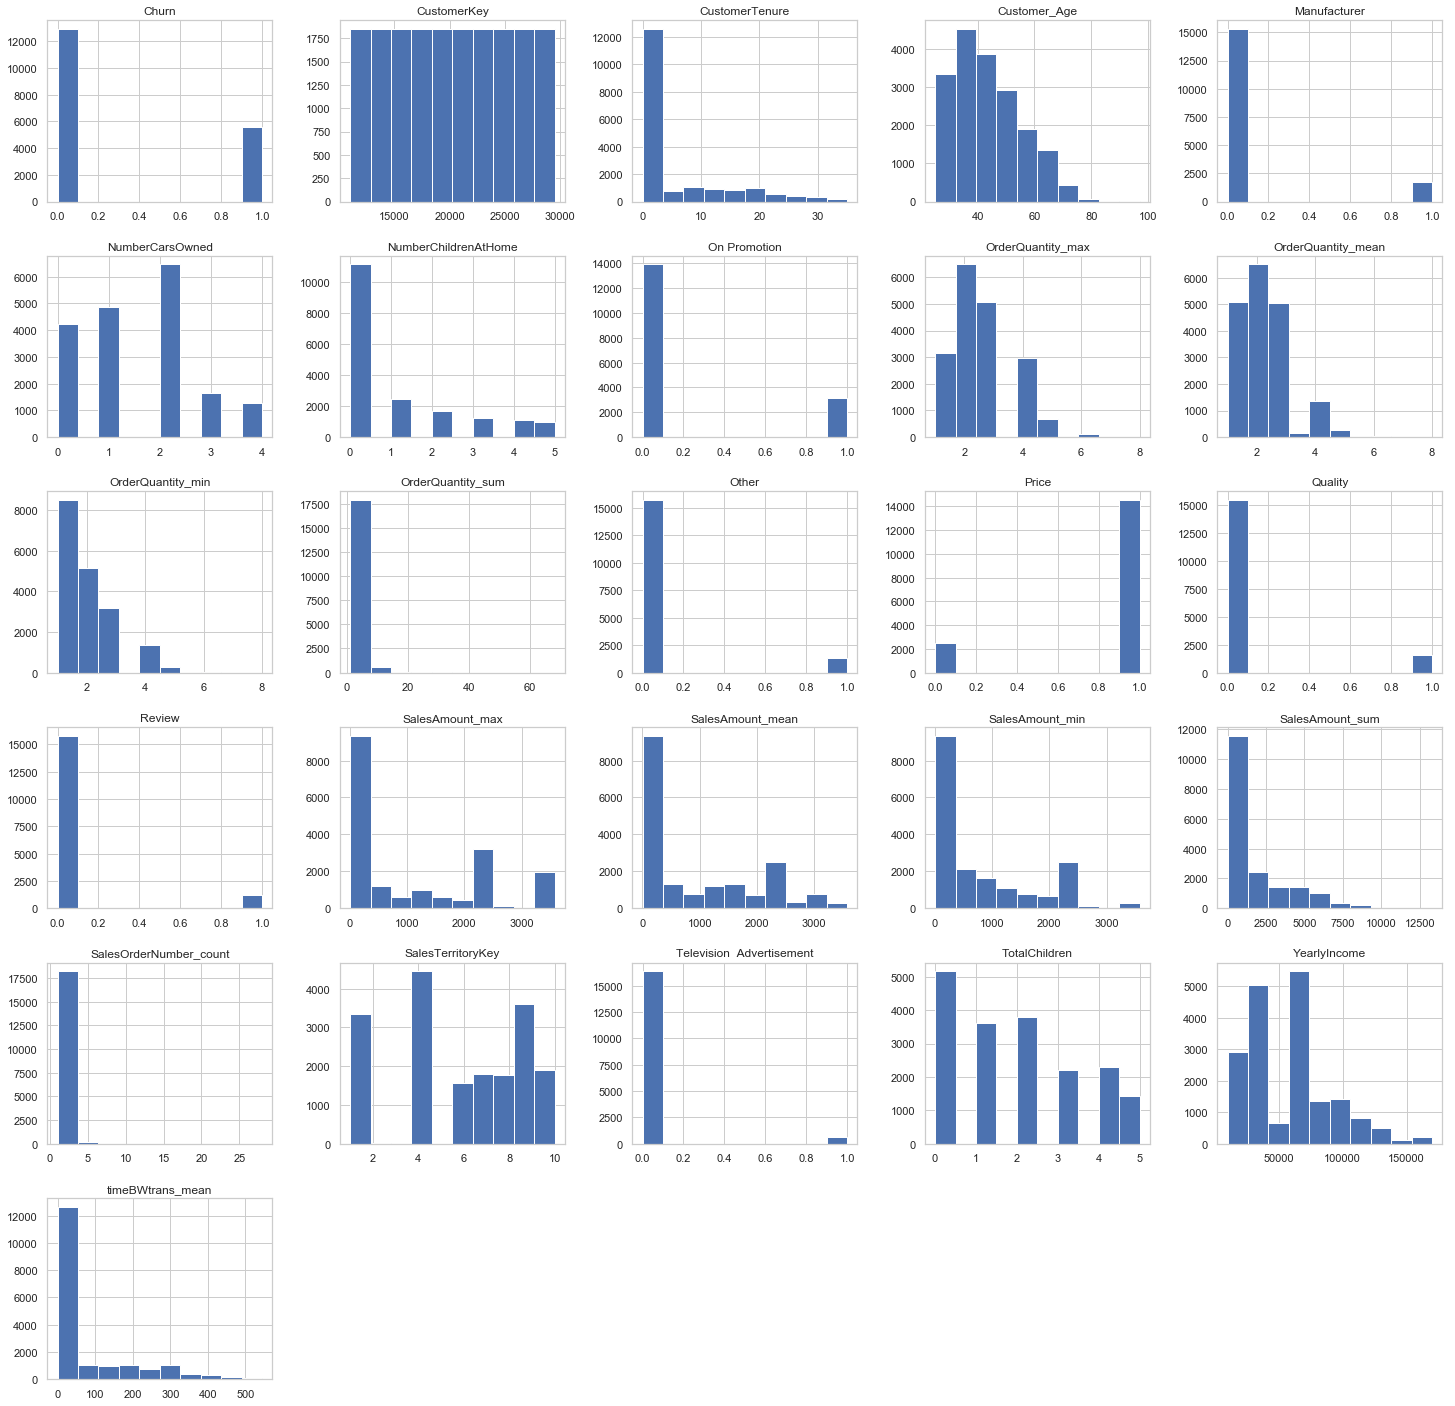

In [67]:
final_data.hist(figsize=(25,25))
plt.show()

In [68]:
final_data.dtypes

CustomerKey                           int64
SalesTerritoryKey                     int64
SalesAmount_sum                     float64
SalesAmount_mean                    float64
SalesAmount_min                     float64
SalesAmount_max                     float64
SalesOrderNumber_count                int64
OrderDate_min                datetime64[ns]
OrderDate_max                datetime64[ns]
timeBWtrans_mean                    float64
OrderQuantity_sum                     int64
OrderQuantity_mean                  float64
OrderQuantity_min                     int64
OrderQuantity_max                     int64
BirthDate                            object
MaritalStatus                        object
Gender                               object
YearlyIncome                        float64
TotalChildren                         int64
NumberChildrenAtHome                  int64
EnglishEducation                     object
EnglishOccupation                    object
HouseOwnerFlag                  

In [69]:
# Exclude features that have to do with time or dates
numerics = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64','object']
final_data = final_data.select_dtypes(include=numerics)

In [70]:
final_data.dtypes

CustomerKey                    int64
SalesTerritoryKey              int64
SalesAmount_sum              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_max              float64
SalesOrderNumber_count         int64
timeBWtrans_mean             float64
OrderQuantity_sum              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_max              int64
BirthDate                     object
MaritalStatus                 object
Gender                        object
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
EnglishEducation              object
EnglishOccupation             object
HouseOwnerFlag                object
NumberCarsOwned                int64
DateFirstPurchase             object
CommuteDistance               object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
P

In [71]:
# Exclude features that are keys
final_data.drop(['CustomerKey','SalesTerritoryKey', 'timeBWtrans_mean', 'BirthDate','DateFirstPurchase' ], axis=1,inplace=True)

In [ ]:
#Excuding these sets of features is needed so that scoring data and your new dataste will have the same datatypes per feature

In [72]:
final_data.dtypes

SalesAmount_sum              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_max              float64
SalesOrderNumber_count         int64
OrderQuantity_sum              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_max              int64
MaritalStatus                 object
Gender                        object
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
EnglishEducation              object
EnglishOccupation             object
HouseOwnerFlag                object
NumberCarsOwned                int64
CommuteDistance               object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
Television  Advertisement    float64
CustomerTenure                 int32
C

In [73]:
final_data['Churn'].value_counts()

0    12925
1     5559
Name: Churn, dtype: int64

- At this point, I am going to divide the data into churners & nonchurners
- churners are 5559, non-churners are 12925

In [74]:
churners = final_data.loc[final_data['Churn'] == 1]

In [75]:
churners['Churn'].value_counts()

1    5559
Name: Churn, dtype: int64

In [76]:
non_churners = final_data.loc[final_data['Churn'] == 0]

In [77]:
non_churners['Churn'].value_counts()

0    12925
Name: Churn, dtype: int64

- the next step is to divide the non_churners into 2 groups:
- one group for trainning and testing
- the other group for scoring the model
- I will employ the train_test_split method for this

In [78]:
scoring_data,non_churners = train_test_split(non_churners,test_size=0.5,random_state=30)

- now I check the number of non_churners again

In [79]:
non_churners['Churn'].value_counts()

0    6463
Name: Churn, dtype: int64

- the number has reduced, just as we intended

In [80]:
# THIS IS MY SCORING DATA
scoring_data['Churn'].value_counts()

0    6462
Name: Churn, dtype: int64

### I am bringing together the non-CHURNERS & CHURNERS DATASTETS TO FORM ONE BIG ONE

In [81]:
modeling_data = pd.concat([churners,non_churners],ignore_index=True)

In [82]:
from matplotlib import pyplot as plt
import seaborn as sns

# Exploratory Data Analysis

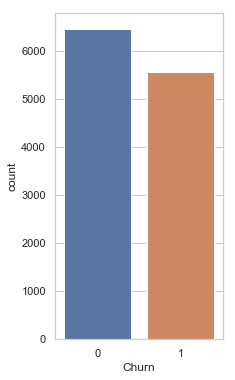

In [83]:
plt.figure(figsize=(3,6))
sns.countplot(x='Churn', data=modeling_data)

## Churn & Children

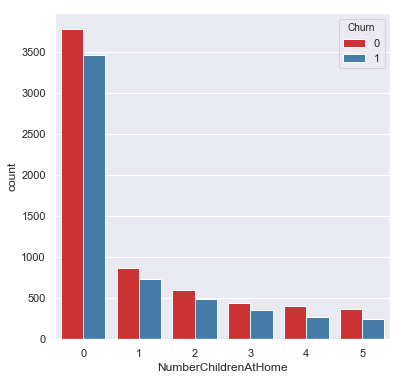

In [84]:
sns.set(style="darkgrid")
plt.figure(figsize=(6,6))
sns.countplot(x='NumberChildrenAtHome',
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
# customers who are more likely to churn have fewer children than those who won't churn

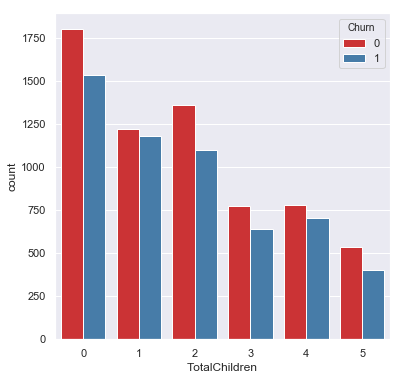

In [85]:
sns.set(style="darkgrid")
plt.figure(figsize=(6,6))
sns.countplot(x='TotalChildren',
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
# customers with fewer total number of children in general are more likely to churn

In [ ]:
## Churn & Customer Educational Background

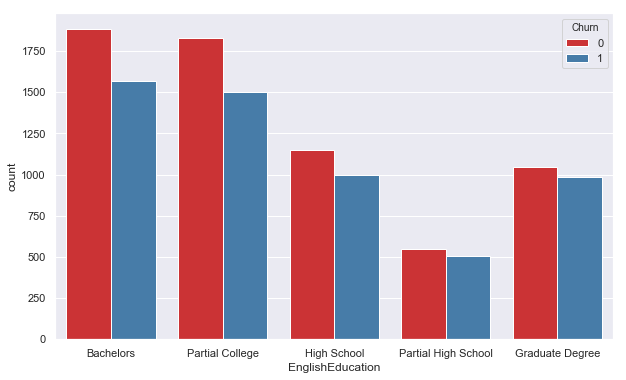

In [86]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.countplot(x='EnglishEducation',
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
# th data shows non-churners are more likely to have adegree of some kind than churners

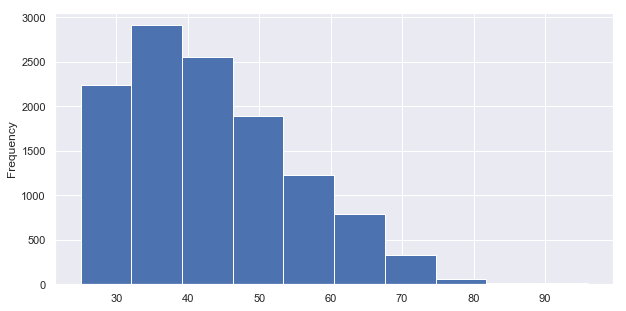

In [87]:
modeling_data['Customer_Age'].plot.hist(bins=10, figsize=(10,5))
# from the vizualisation we can tell that majority of the customers are between the ages of 30 and 50

Text(0.5, 0, 'Customer_Age')

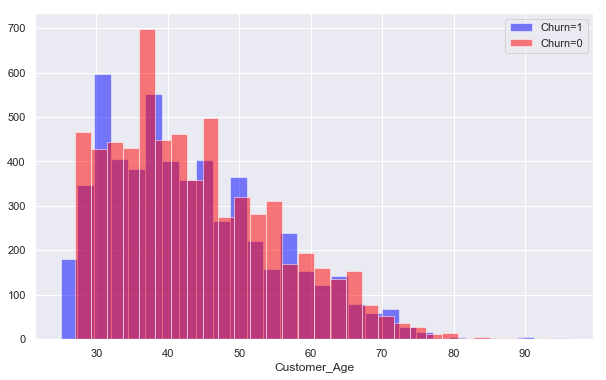

In [88]:
plt.figure(figsize=(10,6))
modeling_data[modeling_data['Churn']==1]['Customer_Age'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Churn=1')
modeling_data[modeling_data['Churn']==0]['Customer_Age'].hist(alpha=0.5,color='red',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('Customer_Age')

In [ ]:
## Churn & Customer Occupation

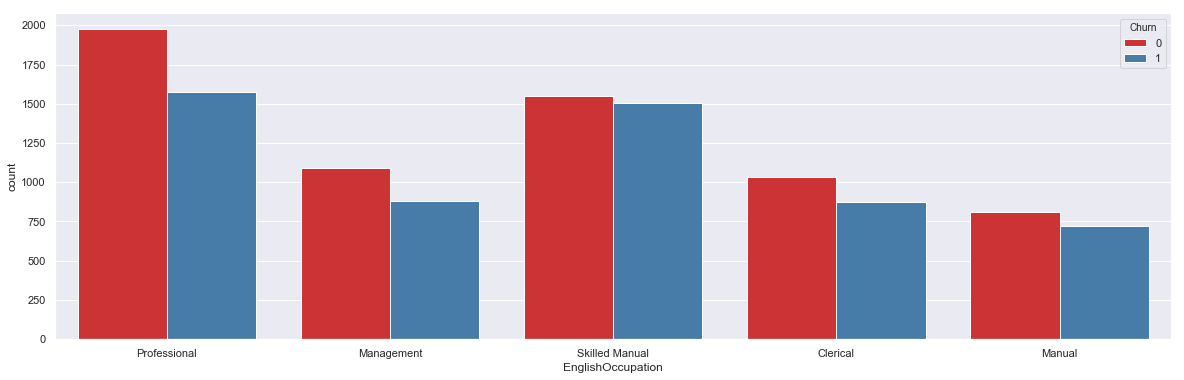

In [90]:
sns.set(style="darkgrid")
plt.figure(figsize=(20,6))
sns.countplot(x='EnglishOccupation',                    
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
 # From the visualization, we can tell that a bulk of potential churners happen to have professional 
# and skilled manual occupations

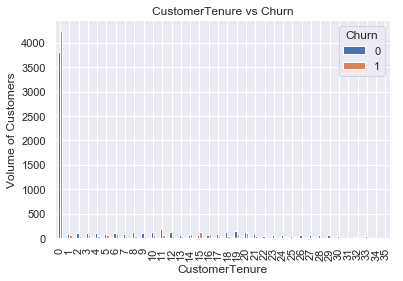

<Figure size 1440x432 with 0 Axes>

In [88]:
pd.crosstab(modeling_data.CustomerTenure,modeling_data.Churn).plot(kind='bar')
plt.title('CustomerTenure vs Churn')
plt.xlabel('CustomerTenure')
plt.ylabel('Volume of Customers')

plt.figure(figsize = (20,6))

plt.savefig('pur_fre_pout_bar')
# Customers are most likley to churn if they have been customers for less than 12 months.

Text(0.5, 0, 'CustomerTenure')

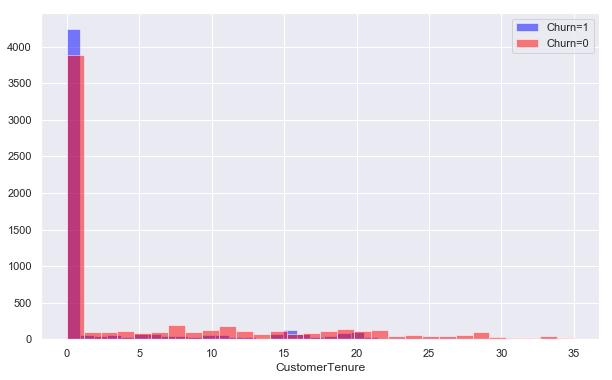

In [89]:
plt.figure(figsize=(10,6))
modeling_data[modeling_data['Churn']==1]['CustomerTenure'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Churn=1')
modeling_data[modeling_data['Churn']==0]['CustomerTenure'].hist(alpha=0.5,color='red',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('CustomerTenure')

In [ ]:
## Churn & Customer Gender

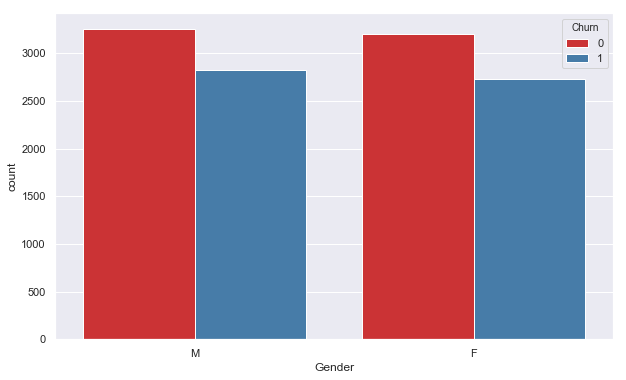

In [91]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.countplot(x='Gender',                    
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()

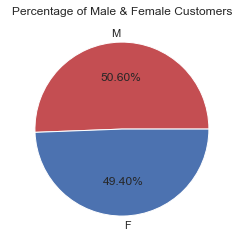

In [92]:
M = modeling_data.loc[modeling_data['Gender'] == 'M'].count()[0]
F = modeling_data.loc[modeling_data['Gender'] == 'F'].count()[0]

labels = ['M', 'F']
colors = ['r', 'b']

plt.pie([M, F], labels=labels, colors=colors, autopct='%.2f%%')

plt.title('Percentage of Male & Female Customers')
plt.show() 

In [ ]:
## Churn & House Ownership

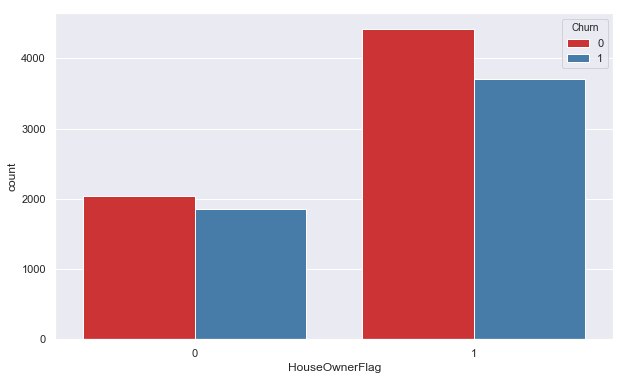

In [93]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.countplot(x='HouseOwnerFlag',                    
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()

In [ ]:
## Churn & Yearly Income

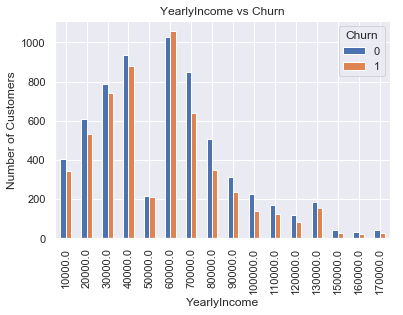

In [92]:
pd.crosstab(modeling_data.YearlyIncome,modeling_data.Churn).plot(kind='bar')
plt.title('YearlyIncome vs Churn')
plt.xlabel('YearlyIncome')
plt.ylabel('Number of Customers')


plt.savefig('pur_fre_pout_bar')
# larger number of non-churners than churners hence it appears as if non-churners earn more than churners in general

In [ ]:
## Churn & Commute Distance

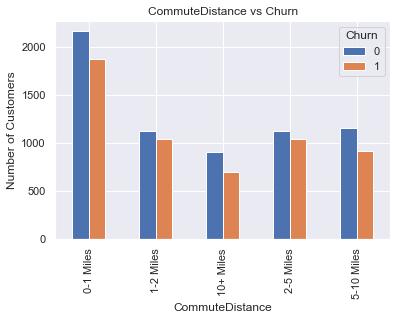

In [93]:
pd.crosstab(modeling_data.CommuteDistance,modeling_data.Churn).plot(kind='bar')
plt.title('CommuteDistance vs Churn')
plt.xlabel('CommuteDistance')
plt.ylabel('Number of Customers')


plt.savefig('pur_fre_pout_bar')
# Customers who travel less than 1 Mile to work are more likely to churn

In [ ]:
## Churn & Marital Status

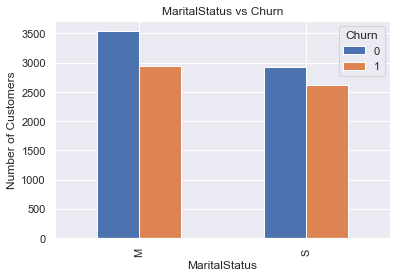

In [94]:
pd.crosstab(modeling_data.MaritalStatus,modeling_data.Churn).plot(kind='bar')
plt.title('MaritalStatus vs Churn')
plt.xlabel('MaritalStatus')
plt.ylabel('Number of Customers')


plt.savefig('pur_fre_pout_bar')

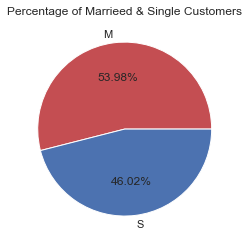

In [95]:
M = modeling_data.loc[modeling_data['MaritalStatus'] == 'M'].count()[0]
S = modeling_data.loc[modeling_data['MaritalStatus'] == 'S'].count()[0]

labels = ['M', 'S']
colors = ['r', 'b']

plt.pie([M, S], labels=labels, colors=colors, autopct='%.2f%%')

plt.title('Percentage of Marrieed & Single Customers')
plt.show() 

In [82]:
#measures of central tendencies - investigating the difference between the averages of independent variables vs the target variables
modeling_data.groupby('Churn').mean()

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,YearlyIncome,...,NumberCarsOwned,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age
Churn,,,,,,,,,,,,,,,,,,,,,
0,1631.944412,874.415895,715.014440,1035.401284,1.595853,3.512610,2.266315,1.896333,2.646604,58101.500851,...,1.527309,0.077704,0.190849,0.080366,0.872379,0.068220,0.075874,0.04426,5.897571,44.017794
1,1503.142648,1013.761415,883.673023,1143.002904,1.268214,2.689333,2.161540,1.944414,2.378305,55538.765965,...,1.466631,0.151131,0.170567,0.066045,0.800079,0.143792,0.063269,0.02380,2.972297,43.202015


In [83]:
modeling_data.isnull().sum()

SalesAmount_sum                0
SalesAmount_mean               0
SalesAmount_min                0
SalesAmount_max                0
SalesOrderNumber_count         0
OrderQuantity_sum              0
OrderQuantity_mean             0
OrderQuantity_min              0
OrderQuantity_max              0
MaritalStatus                  0
Gender                         0
YearlyIncome                   0
TotalChildren                  0
NumberChildrenAtHome           0
EnglishEducation               0
EnglishOccupation              0
HouseOwnerFlag                 0
NumberCarsOwned                0
CommuteDistance                0
Manufacturer                 970
On Promotion                 970
Other                        970
Price                        970
Quality                      970
Review                       970
Television  Advertisement    970
CustomerTenure                 0
Customer_Age                   0
Churn                          0
dtype: int64

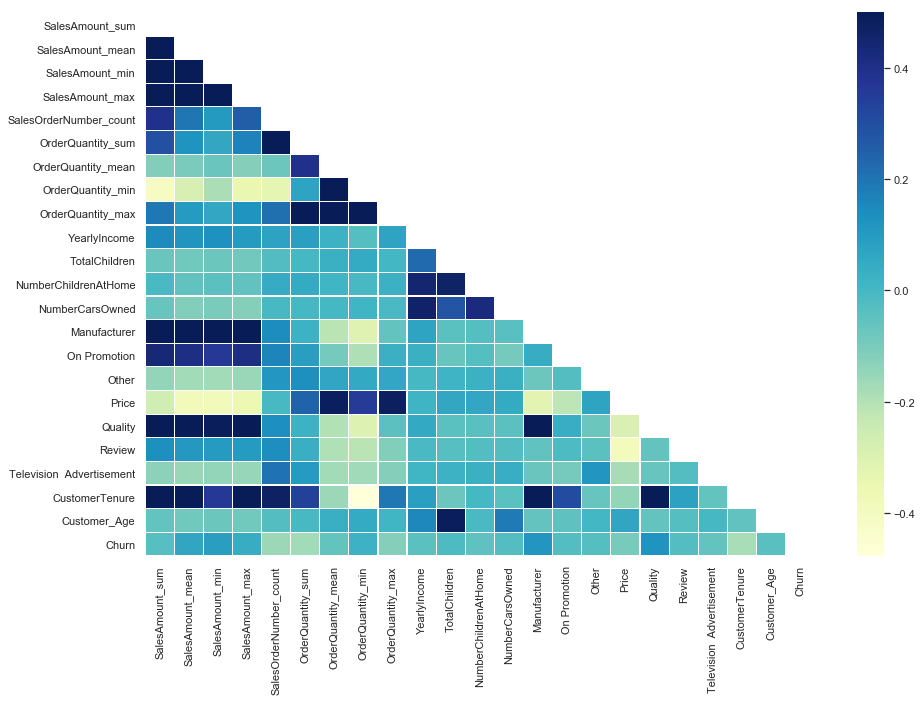

In [84]:
# Calculate correlations
corr = modeling_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr,
            vmax=.5,
            mask=mask,
            # annot=True, fmt='.2f',
            linewidths=.2, cmap="YlGnBu")

# Identify missing values

In [85]:
modeling_data.isnull().mean().sort_values(ascending=False)*100

Manufacturer                 8.068541
Television  Advertisement    8.068541
Review                       8.068541
Quality                      8.068541
Price                        8.068541
Other                        8.068541
On Promotion                 8.068541
SalesOrderNumber_count       0.000000
OrderQuantity_max            0.000000
OrderQuantity_min            0.000000
OrderQuantity_mean           0.000000
OrderQuantity_sum            0.000000
Churn                        0.000000
SalesAmount_max              0.000000
SalesAmount_min              0.000000
Gender                       0.000000
SalesAmount_mean             0.000000
MaritalStatus                0.000000
EnglishEducation             0.000000
YearlyIncome                 0.000000
TotalChildren                0.000000
NumberChildrenAtHome         0.000000
Customer_Age                 0.000000
EnglishOccupation            0.000000
HouseOwnerFlag               0.000000
NumberCarsOwned              0.000000
CommuteDista

In [86]:
#replace missing values with most frequent values
modeling_data = modeling_data.fillna(modeling_data.mode().iloc[0])

In [87]:
# re-check to see all values are filled
modeling_data.isnull().sum()

SalesAmount_sum              0
SalesAmount_mean             0
SalesAmount_min              0
SalesAmount_max              0
SalesOrderNumber_count       0
OrderQuantity_sum            0
OrderQuantity_mean           0
OrderQuantity_min            0
OrderQuantity_max            0
MaritalStatus                0
Gender                       0
YearlyIncome                 0
TotalChildren                0
NumberChildrenAtHome         0
EnglishEducation             0
EnglishOccupation            0
HouseOwnerFlag               0
NumberCarsOwned              0
CommuteDistance              0
Manufacturer                 0
On Promotion                 0
Other                        0
Price                        0
Quality                      0
Review                       0
Television  Advertisement    0
CustomerTenure               0
Customer_Age                 0
Churn                        0
dtype: int64

In [88]:
modeling_data.head()

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,MaritalStatus,...,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Churn
0,8248.99,2749.663333,2341.97,3399.99,3,8,2.666667,1,5,M,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,27,41,1
1,8114.04,2704.680000,2294.99,3399.99,3,4,1.333333,1,2,M,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25,42,1
2,8139.29,2713.096667,2318.96,3399.99,3,9,3.000000,1,4,S,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28,39,1
3,8196.01,2732.003333,2376.96,3399.99,3,6,2.000000,1,3,S,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27,33,1
4,8121.33,2707.110000,2362.27,3374.99,3,6,2.000000,1,4,S,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,28,36,1


In [89]:
#Carry out a statistical test to understand key statistical elements
modeling_data.describe()

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,YearlyIncome,...,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Churn
count,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,...,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000
mean,1572.386185,938.849579,793.002550,1085.156517,1.444352,3.131925,2.217867,1.918566,2.522542,56916.486442,...,0.102229,0.166944,0.067876,0.852354,0.094410,0.064465,0.032108,4.544918,43.640576,0.462402
std,2073.165729,1067.085284,955.005194,1254.106870,1.019332,2.421769,0.937717,1.051272,1.109862,31969.687301,...,0.302962,0.372941,0.251543,0.354763,0.292411,0.245590,0.176294,7.971881,11.580248,0.498605
min,2.290000,2.290000,2.290000,2.290000,1.000000,1.000000,1.000000,1.000000,1.000000,10000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000
25%,48.970000,39.980000,38.880000,42.840000,1.000000,2.000000,1.500000,1.000000,2.000000,30000.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.000000
50%,539.990000,229.860000,229.860000,254.335000,1.000000,3.000000,2.000000,2.000000,2.000000,60000.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,41.000000,0.000000
75%,2502.030000,1888.828083,1249.840000,2325.960000,2.000000,4.000000,3.000000,3.000000,3.000000,70000.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,7.000000,51.000000,1.000000
max,13295.380000,3578.270000,3578.270000,3578.270000,28.000000,65.000000,8.000000,8.000000,8.000000,170000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,96.000000,1.000000


In [90]:
# check data types
modeling_data.dtypes

SalesAmount_sum              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_max              float64
SalesOrderNumber_count         int64
OrderQuantity_sum              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_max              int64
MaritalStatus                 object
Gender                        object
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
EnglishEducation              object
EnglishOccupation             object
HouseOwnerFlag                object
NumberCarsOwned                int64
CommuteDistance               object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
Television  Advertisement    float64
CustomerTenure                 int32
C

In [91]:
# re-check data types
modeling_data.dtypes

SalesAmount_sum              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_max              float64
SalesOrderNumber_count         int64
OrderQuantity_sum              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_max              int64
MaritalStatus                 object
Gender                        object
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
EnglishEducation              object
EnglishOccupation             object
HouseOwnerFlag                object
NumberCarsOwned                int64
CommuteDistance               object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
Television  Advertisement    float64
CustomerTenure                 int32
C

In [92]:
modeling_data.head()

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,MaritalStatus,...,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Churn
0,8248.99,2749.663333,2341.97,3399.99,3,8,2.666667,1,5,M,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,27,41,1
1,8114.04,2704.680000,2294.99,3399.99,3,4,1.333333,1,2,M,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25,42,1
2,8139.29,2713.096667,2318.96,3399.99,3,9,3.000000,1,4,S,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28,39,1
3,8196.01,2732.003333,2376.96,3399.99,3,6,2.000000,1,3,S,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27,33,1
4,8121.33,2707.110000,2362.27,3374.99,3,6,2.000000,1,4,S,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,28,36,1


# Variable Selection Using Vote Based Approach

In [93]:
# https://medium.com/@sundarstyles89/variable-selection-using-python-vote-based-approach-faa42da960f0
# Data transformation
# Convert categorical values to numeric using label encoder
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
#http://localhost:8888/notebooks/Downloads/Churn%20Model%20From%20Scratch%20(1).ipynb
#4.-Variable-Selection-using-Python---Vote-based-approach
# Encoding the categorical variable
fit = modeling_data.select_dtypes(include=['object']).fillna('NA').apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    modeling_data[i] = d[i].transform(modeling_data[i].fillna('NA'))

In [94]:
features = modeling_data[modeling_data.columns.difference(['Churn'])]
labels = modeling_data['Churn']

In [95]:
features.dtypes

CommuteDistance                int32
CustomerTenure                 int32
Customer_Age                   int32
EnglishEducation               int32
EnglishOccupation              int32
Gender                         int32
HouseOwnerFlag                 int32
Manufacturer                 float64
MaritalStatus                  int32
NumberCarsOwned                int64
NumberChildrenAtHome           int64
On Promotion                 float64
OrderQuantity_max              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_sum              int64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
SalesAmount_max              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_sum              float64
SalesOrderNumber_count         int64
Television  Advertisement    float64
TotalChildren                  int64
Y

In [96]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [97]:
final_iv, IV = data_vars(modeling_data[modeling_data.columns.difference(['Churn'])],modeling_data.Churn)

In [98]:
IV = IV.rename(columns={'VAR_NAME':'index'})
IV.sort_values(['IV'],ascending=0)

,index,IV
1,CustomerTenure,0.140434
24,SalesOrderNumber_count,0.138245
15,OrderQuantity_sum,0.136602
18,Quality,0.053243
7,Manufacturer,0.046197
12,OrderQuantity_max,0.038193
17,Price,0.031179
27,YearlyIncome,0.015735
22,SalesAmount_min,0.013841
13,OrderQuantity_mean,0.013282


### Apply WOE values to your dataframe columns

In [99]:
transform_vars_list = modeling_data.columns.difference(['Churn'])
transform_prefix = 'new_' # leave this value blank if you need replace the original column values

In [100]:
transform_vars_list

Index(['CommuteDistance', 'CustomerTenure', 'Customer_Age', 'EnglishEducation',
       'EnglishOccupation', 'Gender', 'HouseOwnerFlag', 'Manufacturer',
       'MaritalStatus', 'NumberCarsOwned', 'NumberChildrenAtHome',
       'On Promotion', 'OrderQuantity_max', 'OrderQuantity_mean',
       'OrderQuantity_min', 'OrderQuantity_sum', 'Other', 'Price', 'Quality',
       'Review', 'SalesAmount_max', 'SalesAmount_mean', 'SalesAmount_min',
       'SalesAmount_sum', 'SalesOrderNumber_count',
       'Television  Advertisement', 'TotalChildren', 'YearlyIncome'],
      dtype='object')

In [101]:
for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            modeling_data[transform_prefix + var] = modeling_data[var].apply(lambda x: eval(replace_cmd))
        except:
            modeling_data[transform_prefix + var] = modeling_data[var].apply(lambda x: eval(replace_cmd1))

# Variable Importance using Random Forest

In [102]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,labels)

preds = clf.predict(features)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9800365995674597


In [103]:
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

In [104]:
VI = VI.reset_index()
VI.sort_values(['RF'],ascending=0)

,index,RF
2,Customer_Age,0.113188
21,SalesAmount_mean,0.098438
23,SalesAmount_sum,0.089703
22,SalesAmount_min,0.085041
1,CustomerTenure,0.077812
27,YearlyIncome,0.071150
20,SalesAmount_max,0.070783
0,CommuteDistance,0.042629
26,TotalChildren,0.040374
3,EnglishEducation,0.039623


## Recursive Feature Elimination

In [105]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(features, labels)

C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

In [106]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)
Selected = Selected.reset_index()

In [107]:
Selected[Selected['RFE'] == True]

,index,RFE
0,CommuteDistance,True
1,CustomerTenure,True
2,Customer_Age,True
3,EnglishEducation,True
6,HouseOwnerFlag,True
7,Manufacturer,True
8,MaritalStatus,True
10,NumberChildrenAtHome,True
11,On Promotion,True
12,OrderQuantity_max,True


# Variable Importance using Extratrees Classifier

In [108]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(features, labels)

print(model.feature_importances_)

C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.04770706 0.07750519 0.09727725 0.04522236 0.04045026 0.03382176
 0.02468515 0.00443937 0.03068766 0.03930779 0.03229149 0.00983069
 0.01752373 0.01823016 0.01177225 0.02218798 0.01091941 0.0063985
 0.01236104 0.00442433 0.06742404 0.06834641 0.07203086 0.07160828
 0.01979398 0.00287562 0.04593287 0.06494453]


In [109]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)

In [110]:
FI = FI.reset_index()

In [111]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
2,Customer_Age,0.097277
1,CustomerTenure,0.077505
22,SalesAmount_min,0.072031
23,SalesAmount_sum,0.071608
21,SalesAmount_mean,0.068346
20,SalesAmount_max,0.067424
27,YearlyIncome,0.064945
0,CommuteDistance,0.047707
26,TotalChildren,0.045933
3,EnglishEducation,0.045222


# Chi Square

In [112]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model = SelectKBest(score_func=chi2, k=5)
fit = model.fit(features.abs(), labels)

In [113]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features.columns)

In [114]:
chi_sq = chi_sq.reset_index()

In [115]:
chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
27,YearlyIncome,344844.57
22,SalesAmount_min,107200.40
21,SalesAmount_mean,61807.92
20,SalesAmount_max,31885.95
23,SalesAmount_sum,31531.06
1,CustomerTenure,5626.79
15,OrderQuantity_sum,646.75
24,SalesOrderNumber_count,222.11
18,Quality,142.02
7,Manufacturer,122.82


# L1 feature selection

In [116]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True)

C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [117]:
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)
l1 = l1.reset_index()

In [118]:
l1[l1['L1'] == True]

,index,L1
1,CustomerTenure,True
2,Customer_Age,True
4,EnglishOccupation,True
8,MaritalStatus,True
9,NumberCarsOwned,True
10,NumberChildrenAtHome,True
12,OrderQuantity_max,True
14,OrderQuantity_min,True
15,OrderQuantity_sum,True
18,Quality,True


# Combine all together

In [119]:
from functools import reduce
dfs = [IV, VI, Selected, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

# Vote each variable

In [120]:
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [121]:
score_table['final_score'] = score_table.sum(axis=1)

In [122]:
score_table.sort_values('final_score',ascending=0)

,index,IV,RF,Extratrees,Chi_Square,RFE,L1,final_score
1,CustomerTenure,1,1,1,0,1,1,5
21,SalesAmount_mean,0,1,1,1,0,1,4
2,Customer_Age,0,1,1,0,1,1,4
23,SalesAmount_sum,0,1,1,1,0,1,4
22,SalesAmount_min,0,1,1,1,0,1,4
15,OrderQuantity_sum,1,0,0,0,1,1,3
18,Quality,1,0,0,0,1,1,3
14,OrderQuantity_min,0,0,0,0,1,1,2
20,SalesAmount_max,0,0,0,1,0,1,2
12,OrderQuantity_max,0,0,0,0,1,1,2


# Multicollinearity

In [123]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [124]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [125]:
features = features[list(score_table[score_table['final_score'] >= 2]['index'])]

In [126]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)

In [127]:
list(vif['Features'])

['CustomerTenure',
 'Customer_Age',
 'MaritalStatus',
 'NumberChildrenAtHome',
 'OrderQuantity_min',
 'Quality',
 'SalesAmount_min',
 'SalesOrderNumber_count',
 'Television  Advertisement']

In [128]:
features.describe()

,CustomerTenure,Customer_Age,MaritalStatus,NumberChildrenAtHome,OrderQuantity_min,Quality,SalesAmount_min,SalesOrderNumber_count,Television Advertisement
count,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00,12022.00
mean,4.54,43.64,0.46,0.99,1.92,0.09,793.00,1.44,0.03
std,7.97,11.58,0.50,1.51,1.05,0.29,955.01,1.02,0.18
min,0.00,25.00,0.00,0.00,1.00,0.00,2.29,1.00,0.00
25%,0.00,34.00,0.00,0.00,1.00,0.00,38.88,1.00,0.00
50%,0.00,41.00,0.00,0.00,2.00,0.00,229.86,1.00,0.00
75%,7.00,51.00,1.00,2.00,3.00,0.00,1249.84,2.00,0.00
max,35.00,96.00,1.00,5.00,8.00,1.00,3578.27,28.00,1.00


In [129]:
features.head(5)

,CustomerTenure,Customer_Age,MaritalStatus,NumberChildrenAtHome,OrderQuantity_min,Quality,SalesAmount_min,SalesOrderNumber_count,Television Advertisement
0,27,41,0,0,1,0.00,2341.97,3,0.00
1,25,42,0,3,1,0.00,2294.99,3,0.00
2,28,39,1,0,1,0.00,2318.96,3,0.00
3,27,33,1,5,1,0.00,2376.96,3,0.00
4,28,36,1,0,1,0.00,2362.27,3,0.00


# Descriptive Stats and Visualization - For selected variables

In [130]:
#Merge the best list to churn variable
final_vars = list(vif['Features']) + ['Churn']

In [131]:
df1 = modeling_data[final_vars].fillna(0)

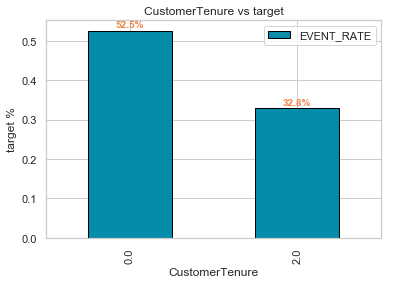

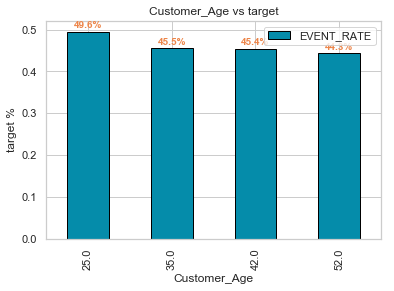

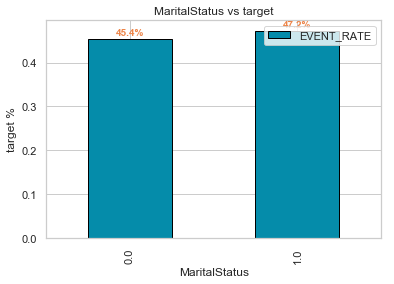

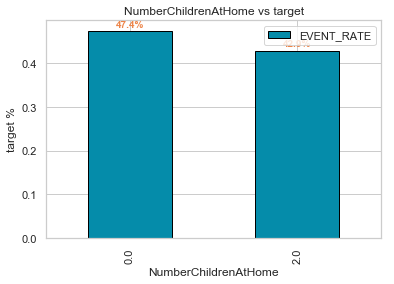

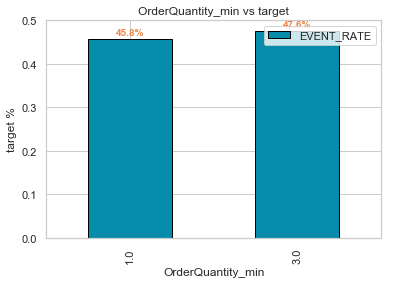

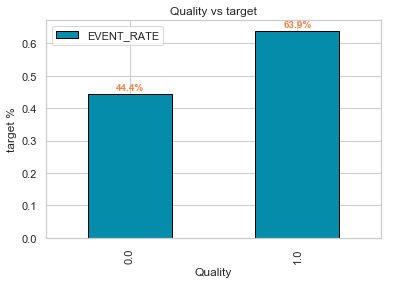

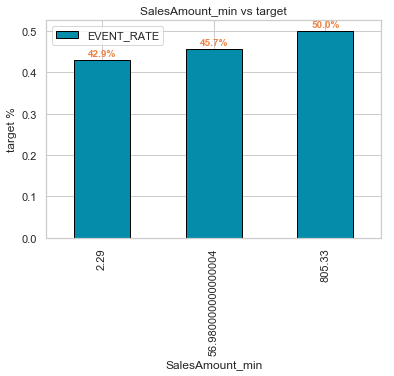

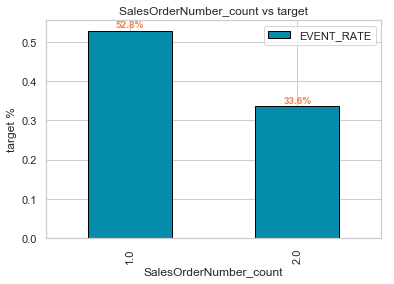

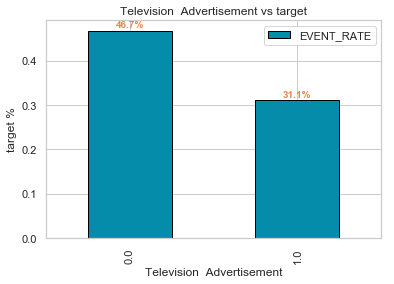

In [132]:
bar_color = '#058caa'
num_color = '#ed8549'

final_iv,_ = data_vars(df1,df1['Churn'])
final_iv = final_iv[(final_iv.VAR_NAME != 'Churn')]
grouped = final_iv.groupby(['VAR_NAME'])
for key, group in grouped:
    ax = group.plot('MIN_VALUE','EVENT_RATE',kind='bar',color=bar_color,linewidth=1.0,edgecolor=['black'])
    ax.set_title(str(key) + " vs " + str('target'))
    ax.set_xlabel(key)
    ax.set_ylabel(str('target') + " %")
    rects = ax.patches
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, str(round(height*100,1)) + '%', 
                ha='center', va='bottom', color=num_color, fontweight='bold')

# Feature Scaling

In [133]:
# import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 5))
HR_col = list(df1.columns)
HR_col.remove('Churn')
for col in HR_col:
    df1[col] = df1[col].astype(float)
    df1[[col]] = scaler.fit_transform(df1[[col]])
df1['Churn'] = pd.to_numeric(df1['Churn'], downcast='float')
df1.head()

,CustomerTenure,Customer_Age,MaritalStatus,NumberChildrenAtHome,OrderQuantity_min,Quality,SalesAmount_min,SalesOrderNumber_count,Television Advertisement,Churn
0,3.86,1.13,0.00,0.00,0.00,0.00,3.27,0.37,0.00,1.00
1,3.57,1.20,0.00,3.00,0.00,0.00,3.21,0.37,0.00,1.00
2,4.00,0.99,5.00,0.00,0.00,0.00,3.24,0.37,0.00,1.00
3,3.86,0.56,5.00,5.00,0.00,0.00,3.32,0.37,0.00,1.00
4,4.00,0.77,5.00,0.00,0.00,0.00,3.30,0.37,0.00,1.00


# Cross Validation

In [135]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size = 0.4, random_state=80)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['Churn']
features_test = test[list(vif['Features'])]
label_test = test['Churn']
#features = list(vif['Features']) 
#labels = ['Churn']

## Cross Validation with Random Forest

In [136]:
#implement cross validation, the cross_val_score method of the sklearn.model_selection library can be used. 
from sklearn.ensemble import RandomForestClassifier  
classifier = RandomForestClassifier(n_estimators=300, random_state=33) 

In [137]:
from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=classifier, X=features_train, y=label_train, cv=10)  

In [138]:
print(all_accuracies) 

[0.64542936 0.66620499 0.65789474 0.64127424 0.6800554  0.67128988
 0.66158114 0.64632455 0.64861111 0.64444444]


In [139]:
#find the average of all the accuracies, simple use the mean() method of the object returned by cross_val_score
print(all_accuracies.mean()) 

0.6563109843037163


In [140]:
#Finally let's find the standard deviation of the data to see degree of variance in the results obtained by our model. To do so, call the std() method on the all_accuracies object
print(all_accuracies.std()) 

0.012492732698717497


## Let's Try Cross Validation using Logistic Regression 

In [141]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [142]:
all_accuracies = cross_val_score(estimator=clf, X=features_train, y=label_train, cv=10) 

C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

In [143]:
print(all_accuracies) 

[0.61634349 0.61218837 0.62880886 0.56094183 0.65235457 0.59361997
 0.5963939  0.61442441 0.59444444 0.62222222]


In [144]:
#find the average of all the accuracies, simple use the mean() method of the object returned by cross_val_score
print(all_accuracies.mean()) 

0.6091742065946676


In [145]:
#Finally let's find the standard deviation of the data to see degree of variance in the results obtained by our model. To do so, call the std() method on the all_accuracies object
print(all_accuracies.std()) 

0.02336014015535009


## Grid Search for Parameter Selection
instead of randomly selecting the values of the parameters, a better approach would be to develop an algorithm which automatically finds the best parameters for a particular model. Grid Search is one such algorithm.

In [184]:
#https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/
grid_param = {  
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [185]:
from sklearn.model_selection import GridSearchCV
gd_sr = GridSearchCV(estimator=classifier,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=10,
                     n_jobs=-1)

In [186]:
#Once the GridSearchCV class is initialized, the last step is to call the fit method of the class and pass it the training and 
#test set, as shown in the following code:
gd_sr.fit(features_train, label_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=300, n_jobs=None,
                                              oob_score=False, random_state=33,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'boot

In [187]:
#the next step is to check the parameters that return the highest accuracy
best_parameters = gd_sr.best_params_  
print(best_parameters)

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100}


In [188]:
#To find the best accuracy achieved, execute the following code:
best_result = gd_sr.best_score_  
print(best_result)

0.6699015666158326


# MODELS

In [146]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size = 0.4, random_state = 33)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['Churn']
features_test = test[list(vif['Features'])]
label_test = test['Churn']

In [147]:
all_features = pd.concat([features_train, features_test])
all_labels = pd.concat([label_train, label_test])

## RANDOM FOREST

In [148]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(pred_test, clf.predict(features_test)))

C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9534174407320116 0.6516947390309836 0.9921130302831683 0.7243608697432651
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.87      2928
         1.0       0.78      0.82      0.80      1881

    accuracy                           0.84      4809
   macro avg       0.83      0.84      0.84      4809
weighted avg       0.84      0.84      0.84      4809



In [149]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,3783,139
1.00,197,3094


In [150]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,1897,644
1.00,1031,1237


# LOGISTIC REGRESSION

In [151]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(pred_test, clf.predict(features_test)))

0.6093165118535977 0.6123934289873154 0.6774390961023458 0.6812148489637667
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2775
         1.0       1.00      1.00      1.00      2034

    accuracy                           1.00      4809
   macro avg       1.00      1.00      1.00      4809
weighted avg       1.00      1.00      1.00      4809



C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\EO\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [152]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,2658,1264
1.00,1554,1737


In [153]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,1726,815
1.00,1049,1219


# NAIVE BAYES

In [154]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(pred_test, clf.predict(features_test)))

0.591848052128102 0.6034518610937825 0.6640841749887001 0.6705748823353441
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1286
         1.0       1.00      1.00      1.00      3523

    accuracy                           1.00      4809
   macro avg       1.00      1.00      1.00      4809
weighted avg       1.00      1.00      1.00      4809



In [155]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,1449,2473
1.00,471,2820


In [156]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,960,1581
1.00,326,1942


# KNN

In [157]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(pred_test, clf.predict(features_test)))

0.7625121308748094 0.620711166562695 0.8454928458325373 0.6802063443477585
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2655
         1.0       1.00      1.00      1.00      2154

    accuracy                           1.00      4809
   macro avg       1.00      1.00      1.00      4809
weighted avg       1.00      1.00      1.00      4809



In [158]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,3083,839
1.00,874,2417


In [159]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,1686,855
1.00,969,1299


# GRADIENT BOOSTING CLASSIFIER

In [211]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(pred_test, clf.predict(features_test)))

0.67988354360183 0.6423372842586816 0.7729248529243369 0.7318479580384343
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2917
         1.0       1.00      1.00      1.00      1892

    accuracy                           1.00      4809
   macro avg       1.00      1.00      1.00      4809
weighted avg       1.00      1.00      1.00      4809



In [212]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,2993,929
1.00,1380,1911


In [213]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,1869,672
1.00,1048,1220


# Performance Tuning For Gradient Boosting

## from sklearn import cross_validation, metrics   
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf}

gb = GradientBoostingClassifier()

gf_tune = GridSearchCV(estimator = gb, param_grid = grid, cv = 2, verbose=2, n_jobs = -1)
gf_tune.fit(features_train, label_train)

print(gf_tune.best_params_)

print(gf_tune.best_params_)

## from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(**gf_tune.best_params_)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Performance Tuning for Random Forest

In [163]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(features_train, label_train)

print(rf_random.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   24.1s finished


{'n_estimators': 445, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


In [218]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**rf_random.best_params_)


clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(pred_test, clf.predict(features_test)))

0.9444059337307639 0.6554377209399044 0.9890741690246342 0.7446904279516112
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2772
         1.0       0.97      0.96      0.97      2037

    accuracy                           0.97      4809
   macro avg       0.97      0.97      0.97      4809
weighted avg       0.97      0.97      0.97      4809



rf_classifier = RandomForestClassifier(class_weight = "balanced",
                                       random_state=7)
param_grid = {'n_estimators': [50, 75, 100, 125, 150, 175],
              'min_samples_split':[2,4,6,8,10],
              'min_samples_leaf': [1, 2, 3, 4],
              'max_depth': [5, 10, 15, 20, 25]}

grid_obj = GridSearchCV(rf_classifier,
                        iid=True,
                        return_train_score=True,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=10)

grid_fit = grid_obj.fit(features_train, label_train)
rf_opt = grid_fit.best_estimator_

print('='*20)
print("best params: " + str(grid_obj.best_estimator_))
print("best params: " + str(grid_obj.best_params_))
print('best score:', grid_obj.best_score_)
print('='*20)

print(accuracy_train,accuracy_test,auc_train,auc_test)

In [165]:
pd.crosstab(all_labels,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,5096,1367
1.00,1443,4116


In [166]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,1824,717
1.00,936,1332


In [167]:
metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])

(array([0.        , 0.        , 0.        , ..., 0.99668536, 0.99719531,
        1.        ]),
 array([0.        , 0.03312063, 0.03342449, ..., 1.        , 1.        ,
        1.        ]),
 array([2.00000000e+00, 1.00000000e+00, 9.99625468e-01, ...,
        5.61797753e-04, 2.80898876e-04, 0.00000000e+00]))

# Train the final model on all the dataset

In [219]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

clf.fit(all_features,all_labels)

pred_train = clf.predict(all_features)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,all_labels)


from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(all_labels), clf.predict_proba(all_features)[:,1])
auc_train = metrics.auc(fpr,tpr)


print(accuracy_train,accuracy_test,auc_train,auc_test)

# Classification report for the optimised RF Regression
clf.fit(features_train, label_train)
print(classification_report(pred_test, clf.predict(features_test)))

0.6673598402927965 0.6554377209399044 0.7602778231697183 0.7446904279516112
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76      2772
         1.0       0.68      0.63      0.65      2037

    accuracy                           0.72      4809
   macro avg       0.71      0.71      0.71      4809
weighted avg       0.72      0.72      0.72      4809



In [220]:
pd.crosstab(all_labels,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,4508,1955
1.00,2839,2720


In [221]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0.0,1.0
ACTUAL,,
0.00,1828,713
1.00,944,1324


In [222]:
import bokeh
#from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_train)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_train), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Train data")
r = p.line(fpr,tpr,color='#0077bc',legend = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)
show(p)

Loading BokehJS ...

In [223]:
#from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Test data")
r = p.line(fpr,tpr,color='#0077bc',legend = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)
show(p)

Loading BokehJS ...

## Decile Plots and KS statistic

In [224]:
from collections import OrderedDict
import pandas as pd
import sys
%matplotlib inline
    
def plot_pandas_style(styler):
    from IPython.core.display import HTML
    html = '\n'.join([line.lstrip() for line in styler.render().split('\n')])
    return HTML(html)

def highlight_max(s,color='yellow'):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: {}'.format(color) if v else '' for v in is_max]

def decile_labels(agg1,label,color='skyblue'):
    agg_dummy = pd.DataFrame(OrderedDict((('TOTAL',0),('TARGET',0),('NONTARGET',0),('PCT_TAR',0),('CUM_TAR',0),('CUM_NONTAR',0),('DIST_TAR',0),('DIST_NONTAR',0),('SPREAD',0))),index=[0])
    agg1 = agg1.append(agg_dummy).sort_index()
    agg1.index.name = label
    agg1 = agg1.style.apply(highlight_max, color = 'yellow', subset=['SPREAD'])
    agg1.bar(subset=['TARGET'], color='{}'.format(color))
    agg1.bar(subset=['TOTAL'], color='{}'.format(color))
    agg1.bar(subset=['PCT_TAR'], color='{}'.format(color))
    return(agg1)

def deciling(data,decile_by,target,nontarget):
    inputs = list(decile_by)
    inputs.extend((target,nontarget))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['TOTAL'] = grouped.sum()[nontarget] + grouped.sum()[target]
    agg1['TARGET'] = grouped.sum()[target]
    agg1['NONTARGET'] = grouped.sum()[nontarget]
    agg1['PCT_TAR'] = grouped.mean()[target]*100
    agg1['CUM_TAR'] = grouped.sum()[target].cumsum()
    agg1['CUM_NONTAR'] = grouped.sum()[nontarget].cumsum()
    agg1['DIST_TAR'] = agg1['CUM_TAR']/agg1['TARGET'].sum()*100
    agg1['DIST_NONTAR'] = agg1['CUM_NONTAR']/agg1['NONTARGET'].sum()*100
    agg1['SPREAD'] = (agg1['DIST_TAR'] - agg1['DIST_NONTAR'])
    agg1 = decile_labels(agg1,'DECILE',color='skyblue')
    return(plot_pandas_style(agg1))

In [225]:
def scoring(features,clf,target):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    score['TARGET'] = target
    score['NONTARGET'] = 1 - target
    return(score)

In [226]:
scores_train = scoring(features_train,clf,label_train)
scores_test = scoring(features_test,clf,label_test)

In [227]:
deciling(scores_train,['DECILE'],'TARGET','NONTARGET')

,TOTAL,TARGET,NONTARGET,PCT_TAR,CUM_TAR,CUM_NONTAR,DIST_TAR,DIST_NONTAR,SPREAD
DECILE,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0
1.0,722,689,33,95.4294,689,33,20.9359,0.841407,20.0945
2.0,721,469,252,65.0485,1158,285,35.1869,7.2667,27.9202
3.0,721,402,319,55.7559,1560,604,47.402,15.4003,32.0017
4.0,721,370,351,51.3176,1930,955,58.6448,24.3498,34.295
5.0,721,352,369,48.8211,2282,1324,69.3406,33.7583,35.5823
6.0,722,345,377,47.7839,2627,1701,79.8238,43.3707,36.453
7.0,721,310,411,42.9958,2937,2112,89.2434,53.8501,35.3933
8.0,721,238,483,33.0097,3175,2595,96.4752,66.1652,30.31


## Lift chart, Actual vs predicted and Gains chart

In [228]:
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt

def plots(agg1,target,type):

    plt.figure(1,figsize=(20, 5))

    plt.subplot(131)
    plt.plot(agg1['DECILE'],agg1['ACTUAL'],label='Actual')
    plt.plot(agg1['DECILE'],agg1['PRED'],label='Pred')
    plt.xticks(range(10,110,10))
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.title('Actual vs Predicted', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + " " + str(type) + " %",fontsize=15)

    plt.subplot(132)
    X = agg1['DECILE'].tolist()
    X.append(0)
    Y = agg1['DIST_TAR'].tolist()
    Y.append(0)
    plt.plot(sorted(X),sorted(Y))
    plt.plot([0, 100], [0, 100],'r--')
    plt.xticks(range(0,110,10))
    plt.yticks(range(0,110,10))
    plt.grid(True)
    plt.title('Gains Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)
    plt.annotate(round(agg1[agg1['DECILE'] == 30].DIST_TAR.item(),2),xy=[30,30], 
            xytext=(25, agg1[agg1['DECILE'] == 30].DIST_TAR.item() + 5),fontsize = 13)
    plt.annotate(round(agg1[agg1['DECILE'] == 50].DIST_TAR.item(),2),xy=[50,50], 
            xytext=(45, agg1[agg1['DECILE'] == 50].DIST_TAR.item() + 5),fontsize = 13)

    plt.subplot(133)
    plt.plot(agg1['DECILE'],agg1['LIFT'])
    plt.xticks(range(10,110,10))
    plt.grid(True)
    plt.title('Lift Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel("Lift",fontsize=15)

    plt.tight_layout()
    

In [229]:
def gains(data,decile_by,target,score):
    inputs = list(decile_by)
    inputs.extend((target,score))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['ACTUAL'] = grouped.mean()[target]*100
    agg1['PRED'] = grouped.mean()[score]*100
    agg1['DIST_TAR'] = grouped.sum()[target].cumsum()/grouped.sum()[target].sum()*100
    agg1.index.name = 'DECILE'
    agg1 = agg1.reset_index()
    agg1['DECILE'] = agg1['DECILE']*10
    agg1['LIFT'] = agg1['DIST_TAR']/agg1['DECILE']
    plots(agg1,target,'Distribution')

In [230]:
lift_train = pd.concat([features_train,scores_train],axis=1)
lift_test = pd.concat([features_test,scores_test],axis=1)

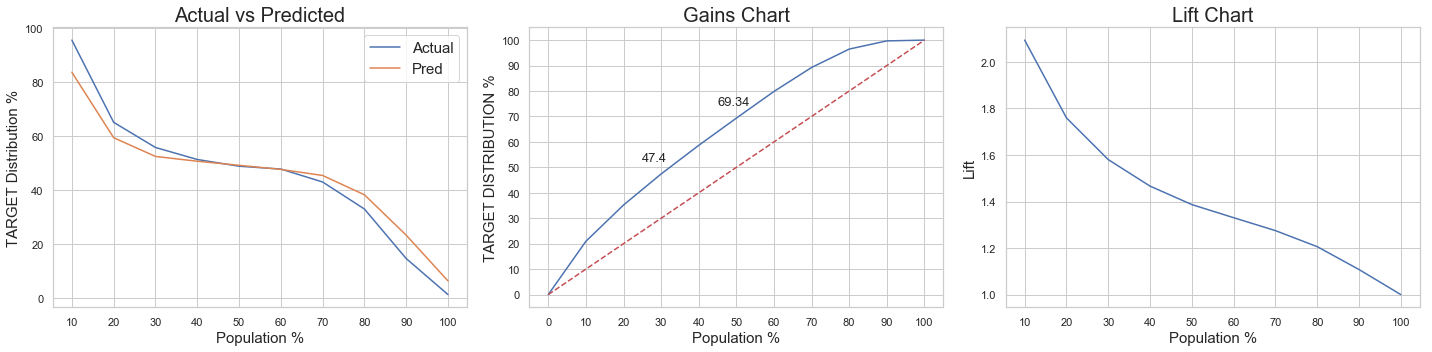

In [231]:
gains(lift_train,['DECILE'],'TARGET','SCORE')

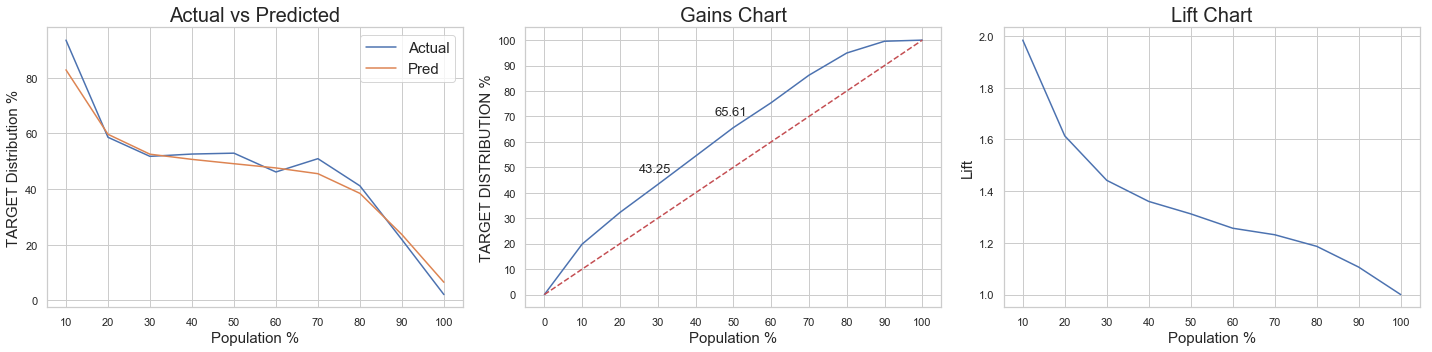

In [232]:
gains(lift_test,['DECILE'],'TARGET','SCORE')

## Save Model for future use

In [233]:
import pandas
from sklearn.externals import joblib

filename = 'final_model.model'
i = [d,clf]
joblib.dump(i,filename)

['final_model.model']

## Score New Data

In [234]:
all_features.dtypes

CustomerTenure               float64
Customer_Age                 float64
MaritalStatus                float64
NumberChildrenAtHome         float64
OrderQuantity_min            float64
Quality                      float64
SalesAmount_min              float64
SalesOrderNumber_count       float64
Television  Advertisement    float64
dtype: object

In [235]:
#Prepare score data to ensure the attributes of the modelling data matches that of the scoring data
#Score_data

#replace missing values with most frequent values
Score_data_sel = scoring_data.fillna(scoring_data.mode().iloc[0])

#Select features and target
Score_data_sel = Score_data_sel[['CustomerTenure',
'Customer_Age',
'MaritalStatus',
'NumberChildrenAtHome',
'OrderQuantity_min',
'Quality',
'SalesAmount_min',
'SalesOrderNumber_count',
'Television  Advertisement']]

In [236]:
#Select features and target
Score_data_sel.head(5)

,CustomerTenure,Customer_Age,MaritalStatus,NumberChildrenAtHome,OrderQuantity_min,Quality,SalesAmount_min,SalesOrderNumber_count,Television Advertisement
7178,7,58,M,5,1,0.00,21.98,2,0.00
12071,0,62,M,0,2,0.00,32.28,1,0.00
5460,5,31,S,0,2,0.00,7.28,2,0.00
892,22,38,M,0,1,0.00,2334.97,3,0.00
13080,0,32,M,2,2,0.00,53.98,1,0.00


In [237]:
Score_data_sel.dtypes

CustomerTenure                 int32
Customer_Age                   int32
MaritalStatus                 object
NumberChildrenAtHome           int64
OrderQuantity_min              int64
Quality                      float64
SalesAmount_min              float64
SalesOrderNumber_count         int64
Television  Advertisement    float64
dtype: object

In [238]:
# https://medium.com/@sundarstyles89/variable-selection-using-python-vote-based-approach-faa42da960f0
# Data transformation
# Convert categorical values to numeric using label encoder
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
#http://localhost:8888/notebooks/Downloads/Churn%20Model%20From%20Scratch%20(1).ipynb
#4.-Variable-Selection-using-Python---Vote-based-approach
# Encoding the categorical variable
fit = Score_data_sel.select_dtypes(include=['object']).fillna('NA').apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    Score_data_sel[i] = d[i].transform(Score_data_sel[i].fillna('NA'))

In [239]:
Score_data_sel.dtypes

CustomerTenure                 int32
Customer_Age                   int32
MaritalStatus                  int32
NumberChildrenAtHome           int64
OrderQuantity_min              int64
Quality                      float64
SalesAmount_min              float64
SalesOrderNumber_count         int64
Television  Advertisement    float64
dtype: object

In [196]:
#Score_data_sel["OrderDate_min"] = pd.to_numeric(Score_data_sel.OrderDate_min, errors='coerce')

In [199]:
#Score_data_sel = pd.get_dummies(Score_data_sel, columns=['SalesRegion'], drop_first = False)

In [240]:
# Use the code to load the model
filename = 'final_model.model'

from sklearn.externals import joblib
d,clf=joblib.load(filename)

In [241]:
#Score the final model (Random Forest) 
pred_train = clf.predict(Score_data_sel)

In [242]:
def score_new(features,clf):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    return(score)

In [243]:
scores = score_new(Score_data_sel,clf)

# Commercial Value

''' 3869 is the number of customers identified to churn. 
By multipling this number with the average customer transaction per year, the company can calculate how much will
be lost if action isn't taken to retain said customers'''

In [244]:
# How many 0s and 1s are there

print('There are', np.count_nonzero(pred_train == 0), '0s')

print('There are', np.count_nonzero(pred_train == 1), '1s')

There are 2593 0s
There are 3869 1s


In [245]:
Score_data_sel.head(5)

,CustomerTenure,Customer_Age,MaritalStatus,NumberChildrenAtHome,OrderQuantity_min,Quality,SalesAmount_min,SalesOrderNumber_count,Television Advertisement
7178,7,58,0,5,1,0.00,21.98,2,0.00
12071,0,62,0,0,2,0.00,32.28,1,0.00
5460,5,31,1,0,2,0.00,7.28,2,0.00
892,22,38,0,0,1,0.00,2334.97,3,0.00
13080,0,32,0,2,2,0.00,53.98,1,0.00


In [ ]:
#Convert 'Score':scores.SCORE, 'Decile':scores.DECILE to list

In [246]:
Score_data_sel.dtypes

CustomerTenure                 int32
Customer_Age                   int32
MaritalStatus                  int32
NumberChildrenAtHome           int64
OrderQuantity_min              int64
Quality                      float64
SalesAmount_min              float64
SalesOrderNumber_count         int64
Television  Advertisement    float64
dtype: object

In [ ]:
## Re attaching the Customer Key to the Scoring data

In [208]:
sLength = len(Score_data_sel['CustomerTenure'])

In [210]:
 Score_data_sel(fis['CustomerKey']) = pd.Series(np.random.randn(sLength), index=df1.index)

SyntaxError: can't assign to function call (<ipython-input-210-f89dcacdb0d2>, line 1)

In [204]:
Score_data_sel.head()

,CommuteDistance,CustomerTenure,Customer_Age,MaritalStatus,NumberCarsOwned,NumberChildrenAtHome,OrderQuantity_min,Quality,SalesAmount_min,SalesOrderNumber_count,SalesRegion,Television Advertisement,CustomerKey
7178,2,7,58,0,3,5,1,0.00,21.98,2,0,0.00,1.43
12071,1,0,62,0,2,0,2,0.00,32.28,1,1,0.00,0.27
5460,3,5,31,1,1,0,2,0.00,7.28,2,0,0.00,0.86
892,0,22,38,0,0,0,1,0.00,2334.97,3,2,0.00,0.15
13080,0,0,32,0,2,2,2,0.00,53.98,1,0,0.00,-1.41


In [205]:
Score_data_sel.head()

,CommuteDistance,CustomerTenure,Customer_Age,MaritalStatus,NumberCarsOwned,NumberChildrenAtHome,OrderQuantity_min,Quality,SalesAmount_min,SalesOrderNumber_count,SalesRegion,Television Advertisement,CustomerKey
7178,2,7,58,0,3,5,1,0.00,21.98,2,0,0.00,1.43
12071,1,0,62,0,2,0,2,0.00,32.28,1,1,0.00,0.27
5460,3,5,31,1,1,0,2,0.00,7.28,2,0,0.00,0.86
892,0,22,38,0,0,0,1,0.00,2334.97,3,2,0.00,0.15
13080,0,0,32,0,2,2,2,0.00,53.98,1,0,0.00,-1.41


In [206]:
# Put the result in a dataframe

#pd.DataFrame({'Customer_ID':non_churners_score.Customer_ID,'Churn_Flag':DecTree_score_pred}).to_csv('Predicted Churners.csv',index=False)
# Store the result in a csv file
#, 'Score':scores.SCORE, 'Decile':scores.DECILE
Final = pd.DataFrame({'CustomerKey':Score_data_sel.CustomerKey,'Churn_Flag':pred_train})

In [207]:
# Merge the Final data to the custtbl to do some demographics profiling
Final_ouput = pd.merge(custmrtble,
                 Final,
                 on='CustomerKey',how = 'inner')
Final_ouput.head()

C:\Users\EO\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Churn_Flag


In [203]:
Final_ouput.count()

CustomerKey             6462
BirthDate               6462
MaritalStatus           6462
Gender                  6462
YearlyIncome            6462
TotalChildren           6462
NumberChildrenAtHome    6462
EnglishEducation        6462
EnglishOccupation       6462
HouseOwnerFlag          6462
NumberCarsOwned         6462
DateFirstPurchase       6462
CommuteDistance         6462
Churn_Flag              6462
dtype: int64

In [204]:
#scores.count()
#pred_train.count()
#Score_data.CustomerKey.count()
#Final.head(5)
#clf.predict_proba(features)
#clf.predict_proba(features)[:,1]
prob = scores[['SCORE']].values.squeeze()

In [205]:
prob

array([0.3, 0.8, 0.3, ..., 0.8, 0.8, 0.8])

In [206]:
#, 'Score':scores.SCORE, 'Decile':scores.DECILE
#Final_ = pd.DataFrame({'CustomerKey':Score_data.CustomerKey,'Score':clf.predict_proba(features)[:,1]})
#Final_ = pd.DataFrame({'CustomerKey':Score_data.CustomerKey,'SCORE':clf.predict_proba(features)[:,1]})
Final_ = pd.DataFrame({'CustomerKey':Score_data_sel.CustomerKey,'Churn_Probability':prob})

In [207]:
Final_.head(5)

,CustomerKey,Churn_Probability
7178,18178,0.30
12071,23071,0.80
5460,16460,0.30
892,11892,0.30
13080,24080,0.80


In [208]:
# Merge the probabilities to the
Final = pd.merge(Final_ouput,
                 Final_,
                 on='CustomerKey',how = 'inner')
Final.head()

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Churn_Flag,Churn_Probability
0,11001,1976-05-10,S,M,60000.00,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles,0.00,0.30
1,11013,1979-08-03,M,M,100000.00,2,0,Bachelors,Management,1,3,2013-04-13,0-1 Miles,0.00,0.30
2,11017,1949-12-24,S,F,20000.00,4,0,High School,Skilled Manual,1,2,2011-01-12,5-10 Miles,0.00,0.30
3,11019,1983-09-04,S,M,40000.00,0,0,High School,Skilled Manual,0,2,2013-02-12,5-10 Miles,0.00,0.00
4,11027,1952-06-05,M,M,30000.00,2,0,Partial College,Clerical,1,2,2011-01-16,5-10 Miles,0.00,0.30
